In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
df = pd.read_csv(r"C:\Users\pasch\Beam-dynamics-surrogate-model\beam_deflection_dataset.csv")

In [3]:
df.head()

,k0,k1,damping,velocity,w_max
0,3.824946e+07,246086.429205,0,50.137138,0.000163
1,6.500999e+07,197732.221959,0,37.772646,0.000105
2,5.195376e+07,231687.128608,0,44.868033,0.000125
3,5.789096e+07,234723.811707,0,19.353973,0.000113
4,7.587654e+07,242295.458148,0,56.473185,0.000096


In [4]:
# Define features and target variable
X = df.drop(columns=["w_max"])
y = df["w_max"]


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [10]:
# Build SVM Pipline (Scaling + SVR)
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])


In [11]:
# Hyperparameter Tuning with Grid Search
param_grid = {
    "svr__kernel": ["rbf"],
    "svr__C": [100, 500],
    "svr__gamma": ["scale", 0.01],
    "svr__epsilon": [1e-5,]
}


In [12]:
# Run Grid Search
svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)


,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"{'svr__C': [100, 500], 'svr__epsilon': [1e-05], 'svr__gamma': ['scale', 0.01], 'svr__kernel': ['rbf']}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [13]:
# Train Optimized SVM Model
best_svm = svm_grid.best_estimator_

In [14]:
# Check best parameters
print("Best SVM Parameters:", svm_grid.best_params_)

Best SVM Parameters: {'svr__C': 100, 'svr__epsilon': 1e-05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [15]:
# Evaluate SVM Model Performance
y_pred_svm = best_svm.predict(X_test)

r2_svm = r2_score(y_test, y_pred_svm)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae_svm = mean_absolute_error(y_test, y_pred_svm)

print("Optimized SVM Performance")
print(f"R²   = {r2_svm:.4f}")
print(f"RMSE = {rmse_svm:.6e}")
print(f"MAE  = {mae_svm:.6e}")


Optimized SVM Performance
R²   = 0.6006
RMSE = 1.768577e-04
MAE  = 1.440992e-04


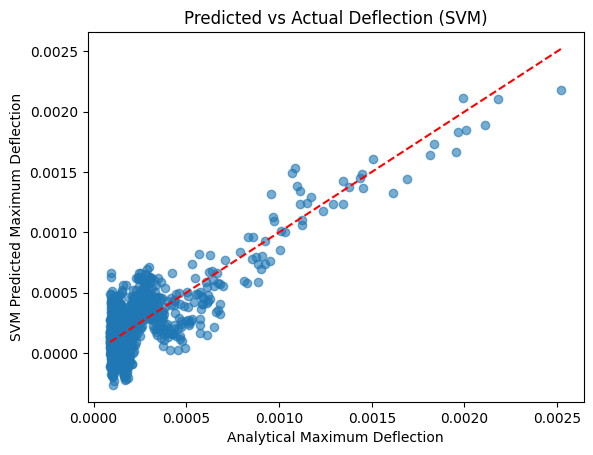

In [16]:
# Predicted vs Actual Plot
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_svm, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.xlabel("Analytical Maximum Deflection")
plt.ylabel("SVM Predicted Maximum Deflection")
plt.title("Predicted vs Actual Deflection (SVM)")
plt.show()
